In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import numpy as np
import seaborn as sns

### Processing of the table

In [4]:
url = "../Data/immigration/immigration_citizenship.csv"
table = pd.read_csv(url)
display(table.head())

/tmp/ipykernel_68001/3655891357.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  table = pd.read_csv(url)


,age,agedef,birth_country,sex,Country,ISO3,1998,1999,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,TOTAL,COMPLET,FOR_STLS,F,Austria,AUT,28638.0,35797.0,NaN,34825.0,...,48788.0,65441.0,55097.0,48739.0,45444.0,46329.0,42715.0,46214.0,97378.0,64503.0
1,TOTAL,COMPLET,FOR_STLS,F,Belgium,BEL,29382.0,33021.0,31296.0,39605.0,...,51236.0,56379.0,50222.0,51820.0,55655.0,59833.0,47172.0,55678.0,93814.0,71027.0
2,TOTAL,COMPLET,FOR_STLS,F,Bulgaria,BGR,NaN,NaN,NaN,NaN,...,7295.0,6276.0,5522.0,5844.0,5960.0,6588.0,6190.0,6852.0,8357.0,18085.0
3,TOTAL,COMPLET,FOR_STLS,F,Switzerland,CHE,36508.0,NaN,42245.0,NaN,...,62616.0,61336.0,59968.0,57238.0,57673.0,57407.0,53380.0,57705.0,66610.0,117356.0
4,TOTAL,COMPLET,FOR_STLS,F,Cyprus,CYP,NaN,NaN,NaN,NaN,...,5630.0,7362.0,7437.0,9498.0,10230.0,11953.0,12580.0,11222.0,15632.0,19850.0


### Graphs of Age groups of people who immigrate

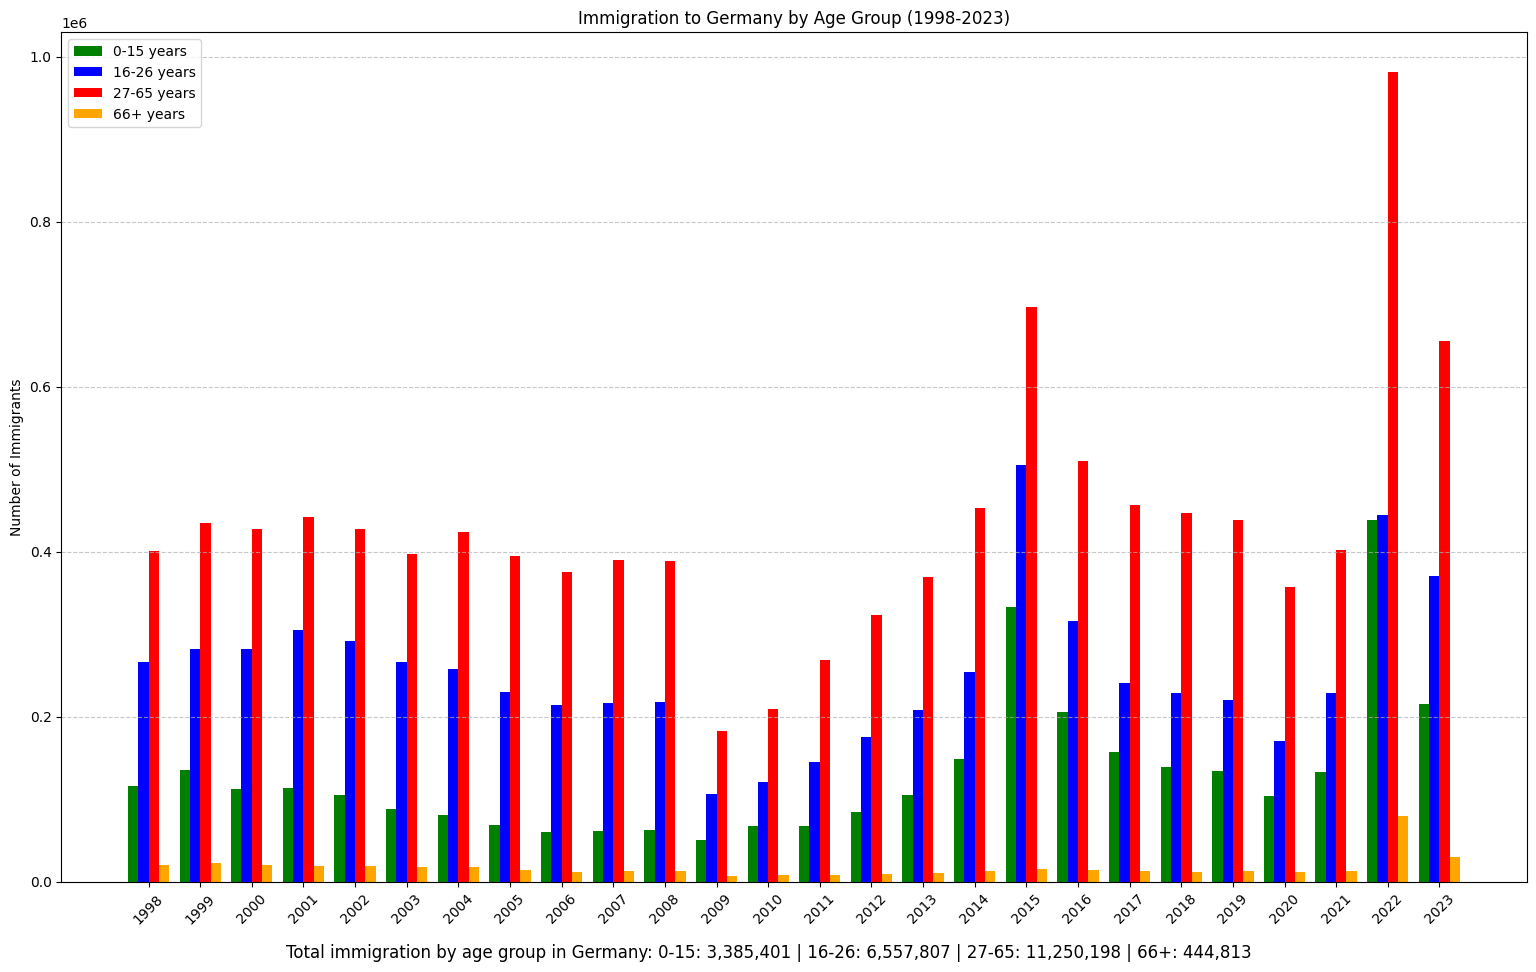

In [ ]:
def country_immigration(country):
    df = table.copy()
    df = df[(df['birth_country'] == 'TOTAL') & (df["agedef"] == "REACH")]
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df = df.dropna(subset=['age'])

    country_data = df[df['Country'] == country]
    # display(country_data)
    try:
        age15 = country_data[(country_data['age'] <= 15) & (country_data['sex'] == 'T')]
        age26 = country_data[(country_data['age'] >= 16) & (country_data['age'] <= 26) & (country_data['sex'] == 'T')]
        age65 = country_data[(country_data['age'] >= 27) & (country_data['age'] <= 65) & (country_data['sex'] == 'T')]
        age100 = country_data[(country_data['age'] >= 66) & (country_data['sex'] == 'T')]


        if len(age15) == 0:
            print(f"No data found for {country} in 0-15 age category")
            return
        elif len(age26) == 0:
            print(f"No data found for {country} in 16-26 age category")
            return
        elif len(age65) == 0:
            print(f"No data found for {country} in 27-65 age category")
            return
        elif len(age100) == 0:
            print(f"No data found for {country} in 66+ age category")
            return

        years = list(range(1998, 2024))
        year_columns = [str(year) for year in years]

        values15 = []
        values26 = []
        values65 = []
        values100 = []
        total15 = 0
        total26 = 0
        total65 = 0
        total100 = 0
        
        for year in year_columns:
            #Changed this code
            #0-15
            val15 = 0
            if year in age15.columns:
                for value in age15[year]:
                    try:
                        val15 += int(value)
                    except:
                        pass
            
            values15.append(val15)
            total15 += val15

            #15-25
            val26 = 0
            if year in age26.columns:
                for value in age26[year]:
                    try:
                        val26 += int(value)
                    except:
                        pass
            
            values26.append(val26)
            total26 += val26

            #26-65
            val65 = 0
            if year in age65.columns:
                for value in age65[year]:
                    try:
                        val65 += int(value)
                    except:
                        pass
            
            values65.append(val65)
            total65 += val65

            #66+

            val100 = 0
            if year in age100.columns:
                for value in age100[year]:
                    try:
                        val100 += int(value)
                    except:
                        pass
            
            values100.append(val100)
            total100 += val100




        global max_min_tracker
        max_min_tracker['0-15'].update_max_min(country, total15)
        max_min_tracker['16-26'].update_max_min(country, total26)
        max_min_tracker['27-65'].update_max_min(country, total65)
        max_min_tracker['66+'].update_max_min(country, total100)

        stats_text = (
            f"Total immigration by age group in {country}: 0-15: {int(total15):,.0f} | 16-26: {int(total26):,.0f} | 27-65: {int(total65):,.0f} | 66+: {int(total100):,.0f}"
        )

        fig, ax = plt.subplots(figsize=(16, 10))
        plt.subplots_adjust(bottom=0.35)
        bar_width = 0.2

        r1 = np.arange(len(years))
        r2 = [x + bar_width for x in r1]
        r3 = [x + bar_width for x in r2]
        r4 = [x + bar_width for x in r3]

        ax.bar(r1, values15, width=bar_width, label="0-15 years", color="green")
        ax.bar(r2, values26, width=bar_width, label="16-26 years", color="blue")
        ax.bar(r3, values65, width=bar_width, label="27-65 years", color="red")
        ax.bar(r4, values100, width=bar_width, label="66+ years", color="orange")

        # ax.set_xlabel('Year') #Is self explanatory (Jakub)
        ax.set_ylabel('Number of Immigrants')
        ax.set_title(f'Immigration to {country} by Age Group (1998-2023)')
        ax.set_xticks([r + bar_width*1.5 for r in range(len(years))])
        ax.set_xticklabels(years, rotation=45)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        plt.figtext(0.5, 0.01, stats_text, ha='center', fontsize=12, wrap=True)
        plt.tight_layout(pad=3, h_pad=2, w_pad=2)

        dir_name = os.path.join("../Images/Countries", country)
        os.makedirs(dir_name, exist_ok=True)

        file_path = os.path.join(dir_name, f"age_groups_immigration_{country.lower()}.png")
        plt.savefig(file_path, bbox_inches='tight')
        # plt.close()

        


    except Exception as e:
        print(f"Error processing {country}: {str(e)}")



class MaxMinTracker:
    def __init__(self):
        self.max_country = ""
        self.max_value = 0
        self.min_country = ""
        self.min_value = float('inf')

    def update_max_min(self, country, value):
        if value > self.max_value:
            self.max_value = value
            self.max_country = country
        if value < self.min_value:
            self.min_value = value
            self.min_country = country

max_min_tracker = {
    '0-15': MaxMinTracker(),
    '16-26': MaxMinTracker(),
    '27-65': MaxMinTracker(),
    '66+': MaxMinTracker()
}

for country in table['Country'].unique():
    country_immigration(country)

# country_immigration("Germany")

# print("\nCountries with most and least immigrants by age group (1998-2023):")
# for age_group, tracker in max_min_tracker.items():
#     print(f"{age_group} years: Most - {tracker.max_country} ({int(tracker.max_value)}), "
#           f"Least - {tracker.min_country} ({int(tracker.min_value)})")


In [8]:
print(table["birth_country"].unique())
print(table["agedef"].unique())

['FOR_STLS' 'NAT' 'TOTAL' 'UNK']
['COMPLET' 'REACH']


### Male-to-Female ratio pie charts

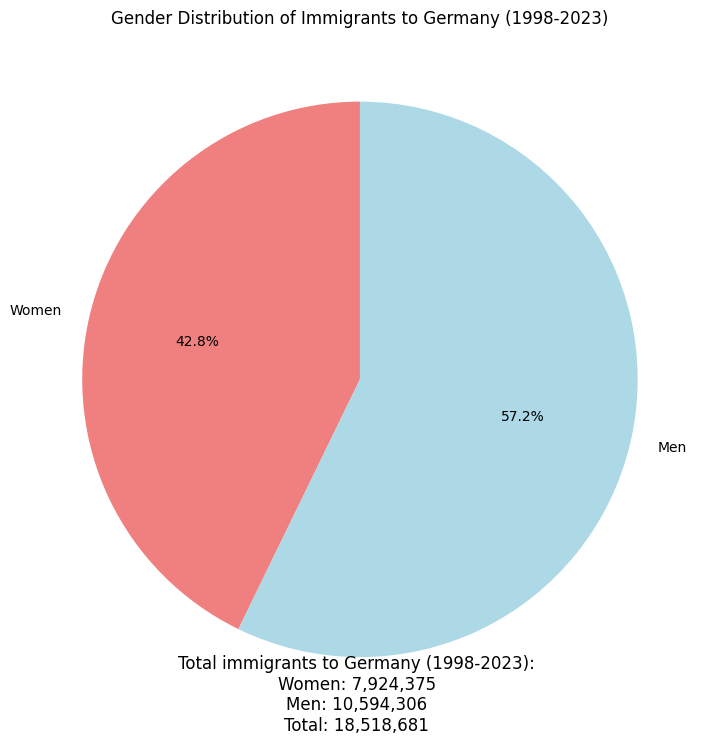

In [5]:
def gender_comparison_pie_chart(country):
    df = table.copy()

    df = df[(df['birth_country'] == 'FOR_STLS') &
            (df["agedef"] == "REACH") &
            (df['Country'] == country)& 
            (df["age"]=="TOTAL")] # this line is important, because otherwise it calculates data twice (Jakub)
    
    #debug
    # display(df)

    years = [str(year) for year in range(1998, 2024)]

    for year in years:
        df[year] = pd.to_numeric(df[year], errors='coerce')

    female_total = df[df['sex'] == 'F'][years].sum().sum()
    male_total = df[df['sex'] == 'M'][years].sum().sum()

    if female_total == 0 and male_total == 0:
        print(f"No data found for {country} in period 1998-2023")
        return

    plt.figure(figsize=(8, 8))
    plt.pie([female_total, male_total],
            labels=['Women', 'Men'],
            autopct='%1.1f%%',
            colors=['lightcoral', 'lightblue'],
            startangle=90)

    plt.title(f'Gender Distribution of Immigrants to {country} (1998-2023)')

    stats_text = (
        f"Total immigrants to {country} (1998-2023):\n"
        f"Women: {female_total:,.0f}\n"
        f"Men: {male_total:,.0f}\n"
        f"Total: {female_total + male_total:,.0f}"
    )

    plt.figtext(0.5, 0.05, stats_text, ha='center', fontsize=12, wrap=True)
    plt.tight_layout(pad=3, h_pad=2, w_pad=2)
    dir_name = os.path.join("../Images/Countries", country)
    os.makedirs(dir_name, exist_ok=True)

    file_path = os.path.join(dir_name, f"gender_ratio_immigration_{country.lower()}.png")
    # plt.savefig(file_path, bbox_inches='tight')
    # plt.close()

#Uncomment to generate
# for country in table['Country'].unique():
#     gender_comparison_pie_chart(country)
gender_comparison_pie_chart("Germany")